---
layout:code-post
title: Perceptron
tags: neural nets
---

This notebook is the first notebook in what will become a regular series
focusing on neural nets. Being the first post, we should start with the
building block of a neural net, the neuron. I am not sure what level I 
will write these posts at, as these mostly exist for me to organize my
thoughts. Being on a public facing website, they shouldn't be entirely in
language that only I recognize, but I probably will not define every
little thing.

Outline:
1. Modelling a neuron
2. Training a neuron
  1. Perceptron algorithm
  2. Stochastic Gradient Descent
  
## 1. Modelling a neuron

The simple model for a neuron $v$ is that it takes in $k$ values
$x_i$ such that $x_i$ is weighted by $w_k$. The output of the
neuron is $\sigma(w\cdot x)$ for some _activation function_ $\sigma$.
Typical choices for $\sigma$ include the sign function, the sigmoid
function, or the rectifified linear unit (ReLU) function. For a 
single neuron, or for the neurons in the first layer in a neural network,
we typically extend the input vector $x$ by adding the constant 1 into
the $k+1$st position.

Let's create a simple class to represent the neuron.

In [13]:
import numpy as np

class Neuron(object):
    
    def __init__(self, weights, activation_function):
        
        self.w = weights
        self.sigma = activation_function
        
    def output(self, x):
        return self.sigma(np.inner(self.w, x))        

The sign function exists in `numpy`, but we will implement a couple of the other activation functions here.

In [14]:
def relu(x):
    return 0 if x < 0 else x

def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

And let's show that the neuron works.

In [15]:
weights = np.array([1, 2, 3])

n = Neuron(weights, sigmoid)

x = np.array([-4, 2, -1])
assert n.output(x) == 1 / (1 + np.exp(3)), "the neuron did not work properly"

## 2. Training

Training a single neuron is a lot simpler than training an entire neural network,
as a single neuron is an example of a linear predictor. For the purposes of this
notebook, I'm going to create an artificial data set that is linearly 
separable.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def make_separable_data():
    """function to make a separable data set of 2000 points in two dimensions."""
    
    # create a separating run
    y_intercept = np.random.uniform(-1, 1)
    slope = np.random.uniform(-2, 2)
    
    data = np.zeros((2000, 4))
    
    # guarantee that cor is positive definite
    # for use in sampling points from multivariate dist
    if slope * slope < 1:
        cor = [[1, slope], [slope, 1]]
    else:
        cor = [[1, 1 / slope], [1/slope, 1]]
    
    def sep_line(x):
        return x * slope + y_intercept
    
    # choose random x near which to put centers of distributions 
    # to draw points from
    x = np.random.uniform(-5, 5)
    
    # the -1 points
    x_1 = x + 1
    y_1 = sep_line(x_1) - 1
    
    n = 0
    while n < 1000:
        point = np.random.multivariate_normal([x_1, y_1], cor)
        if point[1] < sep_line(point[0]) - 0.2:
            data[n,] = np.append(point, [1, -1])
            n += 1
    
    # the +1 points
    x_2 = x - 1
    y_2 = sep_line(x_2) + 1
    
    n = 0
    while n < 1000:
        point = np.random.multivariate_normal([x_2, y_2], cor)
        if point[1] > sep_line(point[0]) + 0.2:
            data[n+1000,] = np.append(point, [1, 1])
            n += 1
    
    return pd.DataFrame(data, columns=['x_1', 'x_2', 'const', 'y'])

In [32]:
data = make_separable_data()

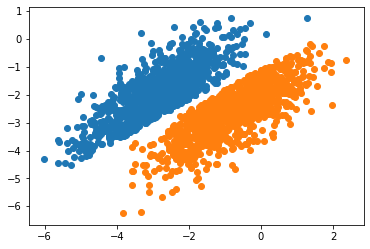

In [33]:
fig, ax = plt.subplots()

ax.scatter(data[data['y']==1]['x_1'], data[data['y']==1]['x_2'])
ax.scatter(data[data['y']==-1]['x_1'], data[data['y']==-1]['x_2'])

plt.show()

### 2.A Perceptron

The perceptron algorithm is an algorithm for learning half-spaces. In other words, we
are training a neuron that has the sign function as its activation function and the
loss function is the 0-1 loss. The perceptron algorithm is an implementation of _Empirical Risk
Minimization (ERM)_ that was proposed by Rosenblatt in 1958, and has the property that
for a separable set of data is guaranteed to stop in polynomial time.

The perceptron works by updating the weights $w^{(t)}$ to be $w^{(t)} + y_i x_i$ where $x_i$ is a 
point that is misclassified given the weights $w^{(t)}$.

In [44]:
def train_perceptron(data):
    """returns a neuron trained via the perceptron algorithm on the data"""
    
    neuron = Neuron(np.zeros(3), np.sign)
    
    exists_mislabeled_point = True
    
    while exists_mislabeled_point:
        mislabeled_points = data[neuron.output(data[['x_1', 'x_2', 'const']]) != data['y']]
        
        if mislabeled_points.shape[0] > 0:
            point = mislabeled_points.sample(1)
            neuron.w = neuron.w + point[['x_1', 'x_2', 'const']].values.reshape(3,) * point['y'].values
        else:
            exists_mislabeled_point = False
    
    return neuron

def get_line(weights):
    """ returns m and b for line y = mx + b from the weights vector"""
    m = -weights[0] / weights[1]
    b = -weights[2] / weights[1]
    
    return m, b

Now let's train a neuron. We then print out the the slope and 
intercept of the line defined by the weights of the neuron.

In [46]:
n = train_perceptron(data)
print(get_line(n.w))

(0.9193596596577078, -0.500980292142552)


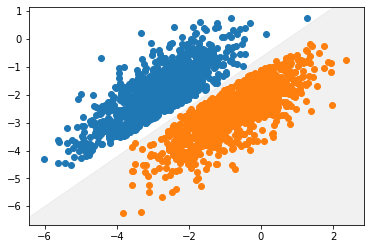

In [41]:
def plot_data_and_separator(data, n):
    """ function to plot the data, shading the two regions that are
    determined by the neurons weights."""
    fig, ax = plt.subplots()

    ax.scatter(data[data['y']==1]['x_1'], data[data['y']==1]['x_2'])
    ax.scatter(data[data['y']==-1]['x_1'], data[data['y']==-1]['x_2'])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fix these as the limist
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlim(xlim[0], xlim[1])

    m, b = get_line(n.w)
    points = np.array([
        [xlim[0], xlim[1]]
        ,[m*xlim[0] + b, m*xlim[1] + b]
    ])

    ax.fill_between(points[0], points[1], ylim[0], color='lightgrey', alpha=0.3, zorder=0)

    plt.show()

plot_data_and_separator(data, n)

### 2.B Stochastic Gradient Descent

The typical method for learning the weights of a neural net is to use Stochastic
Gradient Descent (SGD). While SGD is only guaranteed to converge to the global
minimum for convex problems, a condition that is not satisfied for neural 
networks, it is still used in the hope of finding a useful local minimum. For
a neural network of more than one neuron, backpropagation is used to
calculate the gradient. That is not needed here, and we will show how to use
SGD for half-spaces with the hinge-loss function, as this is a convex
loss function that serves as a surrgoate for the 0-1 loss.

Stochastic gradient descent works by sampling a random point and calculating
the gradient (or a subgradient) of the loss at the point and moving the weights
in the opposite direction from the gradient. The output of SGD is typically
taken to be the the average of the vectors output at each step.

The hinge loss is defined by
$$ f(w) = \max\{0, 1 - y(w\cdot x)\} $$
where the vector $x$ has label $y$. If $1-y(w\cdot x)\leq0$, then a
subgradient of the hinge loss is the zero vector. Othewise a
subgradient is $-yx$.

In [37]:
def train_sgd(data, eta=0.1):
    """returns a neuron trained by stochastic gradient descent"""
    
    # let's take random weights centered about 0
    steps = 1
    
    w = np.random.normal(size=3)
    neuron = Neuron(w, np.sign)
    
    exists_mislabeled_point = True
    while exists_mislabeled_point:

        mislabeled_points = data[neuron.output(data[['x_1', 'x_2', 'const']]) != data['y']]

        if mislabeled_points.shape[0] > 0:
            steps += 1
            point = data.sample(1)

            # calculate the subgradient
            x = point[['x_1', 'x_2', 'const']].values.reshape(3,)
            y = point['y'].values
            val = 1 - y * np.inner(w, x)

            if val <= 0:
                v = np.zeros(3)
            else:
                v = -y * x

            # update
            w = w - eta * v
            neuron.w = ((steps - 1) * neuron.w + w) / steps
        else:
            exists_mislabeled_point = False
        
    return neuron

As a above, we train a neuron and output the slope and intercept of the line
defined by the weights of the neuron.
Note that these will almost certainly be different than the weights found above.

In [42]:
n = train_sgd(data)
print(get_line(n.w))

(0.9053581037692535, -0.5811194919144161)


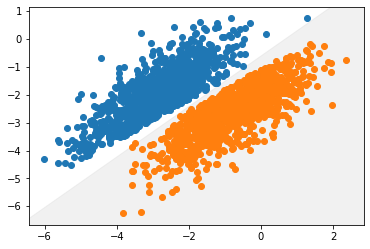

In [43]:
plot_data_and_separator(data, n)